# Predicting and Optimising Instant Loan Values
This notebook includes all the steps for preparing and deploying ML models for predicting and optimising the value of instant loan offer.  

The models are developed to work inreractively with the Ab>Initio Active>360 live demo.  

The notebook implements a three-step process that produces a final model that, given a customer record, predicts the highest value loan offer that can be made to that customer including the interest rate, loan period and monetary value of the optimal loan offer.  A negative monetary value indicates that the optimal loan offer is unlikely to be accepted or repaid.

Two ML models are used, an XGBoots regression model for predicting loan values, and a three-headed deep learning model (Implemented in TensorFlow/Keras) for predicting optimal loan parameters. 

In terms of cloud technologies, the notebook relies on AWS SageMaker, S3, Lambda and API Gateway.


## Table Of Content
1. [Installs, Imports & Environment](#installs)
2. [Predicting Loan Offer Values with XGBoost](#xgboost)
    1. [Read, Clean and Encode Historic Loan Data](#data)
    2. [Defining the XGBoost Model](#xgboost-model)
    3. [XGBoost Training with Hyperparameter Tuning](#xgboost-train)
    4. [Deploying the XGBoost Model](#xgboost-deploy)
    5. [Evaluating the XGBoost Model](#xgboost-eval)
3. [Predicting Optimal Loan Offer Parameters with TensorFlow/Keras](#keras)
    1. [Enriching the Data with Predicted Maximum Loan Value Parameters](#optimisation)
    2. [Data Preparation](#keras-data)
    3. [The Three-Headed Keras Model](#keras-model)
    4. [Training the Keras Model](#keras-train)
    5. [Deploying the Keras Model](#keras-deploy)
    6. [Evaluating the Keras Model](#keras-eval)

<a id="installs"></a>
## 1. Installs, Imports and Environment

### Installs

In [86]:
import sys
!{sys.executable} -m pip install sagemaker pandas scikit-learn==0.22.1 xgboost tensorflow_io tensorboard==2.2.0 pydot graphviz cloudpathlib[s3] --upgrade

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


### Imports

In [58]:
import os
import time
import datetime
from math import sqrt
from statistics import stdev
import json
import pickle

import boto3
import cloudpathlib as cpl
from cloudpathlib import CloudPath

import sagemaker as smk
from sagemaker import get_execution_role
from sagemaker.inputs import TrainingInput
from sagemaker.estimator import Predictor
from sagemaker.tuner import HyperparameterTuner
from sagemaker.tuner import ContinuousParameter
from sagemaker.tuner import IntegerParameter
from sagemaker.tensorflow import TensorFlow
from sagemaker.serializers import CSVSerializer


#The imports in this paragraph are purely there to enable graphical plotting of the model
from xgboost import XGBRegressor
from xgboost import plot_tree
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as ks
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model

# %load_ext tensorboard

import numpy as np
import pandas as pd
import sklearn as skl
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

print("boto3 version", boto3.__version__)
print("cloudpathlib version", cpl.__version__)
from cloudpathlib import CloudPath
print("sagemaker version", smk.__version__)
print("matplotlib version", mpl.__version__)
print("tensorflow version", tf.__version__)
print("keras version", ks.__version__)
print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("sklearn version", skl.__version__)

boto3 version 1.26.135
cloudpathlib version 0.14.0
sagemaker version 2.162.0
matplotlib version 3.5.3
tensorflow version 2.11.0
keras version 2.11.0
numpy version 1.21.6
pandas version 2.0.2
sklearn version 0.22.1


### SageMaker Environment

In [4]:
sm_sess = smk.Session()
s3 = boto3.Session().resource('s3')
bucket = "abinitio-active360-team"
role = get_execution_role()

tags = [
    {"Key": "abinitio:owner", "Value": "tdahl@abinitio.com"},
    {"Key": "abinitio:project", "Value": "active360"},
    {"Key": "abinitio:purpose", "Value": "demo"}
] 

xgb_model_demo_endpoint_name = "demo-do-not-delete-loan-value-xgboost-20230113" # For loading pre-trained model

<a id="xgboost"></a>
## 2. Predicting Loan offer Values with XGBoost

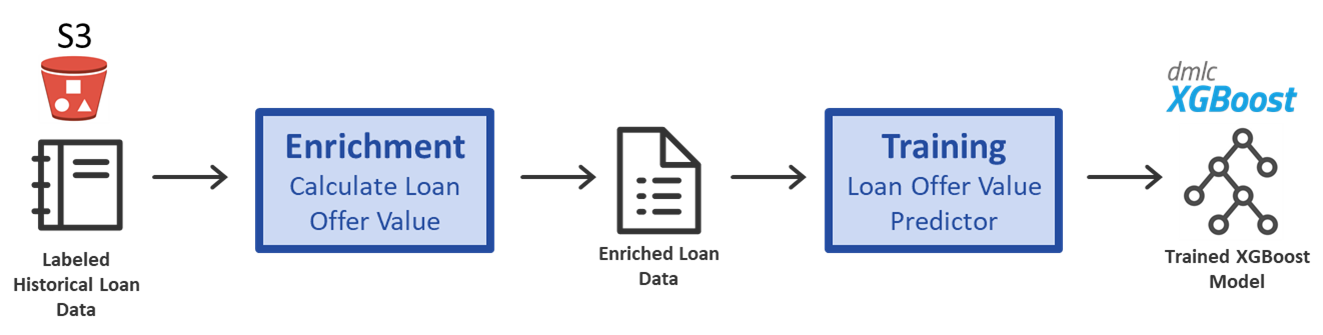

[XGBoost](https://xgboost.readthedocs.io/en/stable/) is a decision tree algorithm with bagging and boosting.

It is fully supported in SageMaker and has been shown to perform as well as deep learning in [some domains](https://towardsdatascience.com/cage-match-xgboost-vs-keras-deep-learning-a8bb2f69a9ab).

<a id="data"></a>
### 2A. Read and Encode Enriched Historical Loan Data

The historical data was enriched by adding an estimate of a loan's value, *v*, to the lender using the following formula, whith loan amount, *a*, interest rate, *i*, and loan period, *p* (in years):


$$
    v = \displaystyle \Bigg\{
    \begin{array}{l}
      -1000, & \mbox{if $loan\_accepted$=$N$ or  $loan\_repaid$=$N$}.\\
      aip, & \mbox{otherwise}.
    \end{array}
$$

A negative value means no load should be offered, as the lender is likely to loose money.

#### Read Data
Historic loan offer data has been synthesized, based on Active>360 information and uploaded to S3 as .csv files.  
The data is enriched with one field, 'loan offer value', which sets a monetary value on each historic loan offer based on the loan amount, interest rate, loan period and whether it was accepted or rejected and paid back or not.

There are two files, each containing 50,000 records for a total of of 100,000 record.  Of these, 80,000 records represent people in employment, 10,000 represent students and 5,000 people in retirement.  

In [5]:
data_loc_hist1 = "s3://{}/{}".format(bucket, "loan-offer/instant-loans-synthesized.csv")
# data_loc_hist2 = "s3://{}/{}".format(bucket, "loan-offer/ML-InstantLoan-income2.csv")
loan_offers_hist1 = pd.read_csv(data_loc_hist1, encoding= "unicode_escape", low_memory=False)
# loan_offers_hist2 = pd.read_csv(data_loc_hist2, encoding= "unicode_escape", low_memory=False)
print("loan_offers_hist1 shape", loan_offers_hist1.to_numpy().shape)
# print("loan_offers_hist2 shape", loan_offers_hist2.to_numpy().shape)

loan_offers_hist = loan_offers_hist1
# loan_offers_hist = pd.concat([loan_offers_hist1, loan_offers_hist2], ignore_index=True)
print("loan_offers_hist shape", loan_offers_hist.to_numpy().shape)

loan_offers_hist1 shape (10000, 27)
loan_offers_hist shape (10000, 27)


In [6]:
print(loan_offers_hist.dtypes)
loan_offers_hist.tail()

customer_id                                  int64
employment_status                           object
monthly_income                               int64
months_in_employment                         int64
homeowner                                   object
assets_under_management                      int64
age                                          int64
bad_debt_flag                               object
pays_in_full_band                           object
pays_on_time_band                           object
total_credit_granted                         int64
current_balance                            float64
total_credit_used                          float64
max_daily_closing_balance_last_90d         float64
avg_daily_closing_balance_last_90d         float64
avg_daily_closing_balance_vs_limit_perc    float64
last_debit_value                           float64
last_debit_channel                          object
last_debit_merchant_class                   object
last_vs_90d_avg_for_merchant_cl

,customer_id,employment_status,monthly_income,months_in_employment,homeowner,assets_under_management,age,bad_debt_flag,pays_in_full_band,pays_on_time_band,...,last_debit_channel,last_debit_merchant_class,last_vs_90d_avg_for_merchant_class_perc,net_promoter_score,days_over_85perc_credit_used_last_90d,loan_amount_offered,loan_rate_offered,loan_term_offered,loan_accepted,loan_repaid
9995,9996,Employed,6178,513,N,93213,43,N,E,E,...,PoS,Travel & Leisure,252,27,6118.73,1440,9.9,24,Y,1. Yes (Smooth)
9996,9997,Employed,4914,328,Y,0,33,N,D,E,...,PoS,Fashion & Luxury,169,74,7537.36,550,11.9,24,N,[null]
9997,9998,Employed,4637,490,N,0,57,N,C,B,...,PoS,Household & Consumer,87,45,2211.55,930,15.9,12,N,[null]
9998,9999,Employed,5805,325,N,33709,34,Y,E,D,...,PoS,Fashion & Luxury,189,50,2285.15,440,15.9,6,N,[null]
9999,10000,Employed,2511,415,N,70437,47,N,A,E,...,Web,Fashion & Luxury,150,4,2754.74,710,15.9,12,N,[null]


#### Clean Data

Remove spaces and convert data types

In [7]:
# Rename badly named columns
loan_offers_hist = loan_offers_hist.rename(columns={" monthly_income ": "monthly_income"})
loan_offers_hist = loan_offers_hist.rename(columns={"loan_rate_offered (R1\x85 R4)": "loan_rate_offered"})
loan_offers_hist = loan_offers_hist.rename(columns={"loan term offered (M3\x85 M24)": "loan term offered"})

# Drop irrelevant columns
irrelevant_columns =  [
    "customer_id",
    "Unnamed: 28",
    "Unnamed: 29",
    "Unnamed: 30",
    "Unnamed: 31",
    "Unnamed: 32",
    "Unnamed: 33",
    "Unnamed: 34",
    "Unnamed: 35",
    "Unnamed: 36",
    "Unnamed: 37",
    "notional risk (drives column X)",
    "loan to income (drives column Y)",
    "accept offer influence (drives column Z)",
    "repayment prob influence (drives column AA)",
    "rate_accept_prob",
    "term_accept_prob",
    "rate_rnd",
    "term_rnd"
]
relevant_fields = [col for col in loan_offers_hist if col not in irrelevant_columns]
loan_offers_hist = loan_offers_hist[relevant_fields]

# Change number strings to int or float
if loan_offers_hist.dtypes['monthly_income'] == 'object':
    loan_offers_hist['monthly_income'] = loan_offers_hist['monthly_income'].apply(lambda x: x.replace(' ', '').replace(',', '')).astype('int')
if loan_offers_hist.dtypes['assets_under_management'] == 'object':
    loan_offers_hist['assets_under_management'] = loan_offers_hist['assets_under_management'].apply(lambda x: x.replace(' ', '').replace(',', '').replace('-', '0')).astype('int')
if loan_offers_hist.dtypes['total_credit_granted'] == 'object':
    loan_offers_hist['total_credit_granted'] = loan_offers_hist['total_credit_granted'].apply(lambda x: x.replace(' ', '').replace(',', '')).astype('int')
if loan_offers_hist.dtypes['current_balance'] == 'object':
    loan_offers_hist['current_balance'] = loan_offers_hist['current_balance'].apply(lambda x: x.replace(' ', '').replace(',', '')).astype('float')
if loan_offers_hist.dtypes['max_daily_closing_balance_last_90d'] == 'object':
    loan_offers_hist['max_daily_closing_balance_last_90d'] = loan_offers_hist['max_daily_closing_balance_last_90d'].apply(lambda x: x.replace(' ', '').replace(',', '')).astype('float')
if loan_offers_hist.dtypes['avg_daily_closing_balance_last_90d'] == 'object':
    loan_offers_hist['avg_daily_closing_balance_last_90d'] = loan_offers_hist['avg_daily_closing_balance_last_90d'].apply(lambda x: x.replace(' ', '').replace(',', '')).astype('float')
if loan_offers_hist.dtypes['days_over_85perc_credit_used_last_90d'] == 'object':
    loan_offers_hist['days_over_85perc_credit_used_last_90d'] = loan_offers_hist['days_over_85perc_credit_used_last_90d'].apply(lambda x: x.replace(' ', '').replace('-', '0')).astype('int')
if loan_offers_hist.dtypes['loan_amount_offered'] == 'object':
    loan_offers_hist['loan_amount_offered'] = loan_offers_hist['loan_amount_offered'].apply(lambda x: x.replace(' ', '').replace(',', '')).astype('float')
if loan_offers_hist.dtypes['loan_term_offered'] == 'object':
    loan_offers_hist['loan_term_offered'] = loan_offers_hist['loan_term_offered'].apply(lambda x: x.replace(' ', '').replace('m', '')).astype('int')
loan_offers_hist['loan_accepted'] = loan_offers_hist['loan_accepted'].apply(lambda x: x.replace(' ', ''))
loan_offers_hist['loan_repaid'] = loan_offers_hist['loan_repaid'].apply(lambda x: x.replace(' ', ''))

print("loan_offers_hist shape", loan_offers_hist.shape)

loan_offers_hist shape (10000, 26)


In [8]:
print(loan_offers_hist.dtypes)
loan_offers_hist.head()

employment_status                           object
monthly_income                               int64
months_in_employment                         int64
homeowner                                   object
assets_under_management                      int64
age                                          int64
bad_debt_flag                               object
pays_in_full_band                           object
pays_on_time_band                           object
total_credit_granted                         int64
current_balance                            float64
total_credit_used                          float64
max_daily_closing_balance_last_90d         float64
avg_daily_closing_balance_last_90d         float64
avg_daily_closing_balance_vs_limit_perc    float64
last_debit_value                           float64
last_debit_channel                          object
last_debit_merchant_class                   object
last_vs_90d_avg_for_merchant_class_perc      int64
net_promoter_score             

,employment_status,monthly_income,months_in_employment,homeowner,assets_under_management,age,bad_debt_flag,pays_in_full_band,pays_on_time_band,total_credit_granted,...,last_debit_channel,last_debit_merchant_class,last_vs_90d_avg_for_merchant_class_perc,net_promoter_score,days_over_85perc_credit_used_last_90d,loan_amount_offered,loan_rate_offered,loan_term_offered,loan_accepted,loan_repaid
0,Employed,734,457,Y,0,55,N,B,A,1662,...,App,Fashion & Luxury,257,84,849.98,300,19.9,6,Y,1.Yes(Smooth)
1,Employed,3207,216,Y,93136,34,N,A,B,2300,...,Web,Household & Consumer,249,89,2936.85,640,17.9,12,N,[null]
2,Employed,1869,365,Y,10644,45,N,B,B,3340,...,Web,Household & Consumer,248,34,2721.14,480,17.9,6,Y,1.Yes(Smooth)
3,Employed,1830,775,N,16718,58,N,B,C,2534,...,PoS,Household & Consumer,99,27,2447.67,300,17.9,6,Y,1.Yes(Smooth)
4,Employed,1402,103,N,0,25,N,A,A,1670,...,PoS,Household & Consumer,150,64,2767.90,320,17.9,6,Y,1.Yes(Smooth)


#### Enrich Data with Calculated Loan Offer Value

The historical data was enriched by adding an estimate of a loan's value, *v*, to the lender using the following formula, whith loan amount, *a*, 1.0 + interest rate, *i*, and loan period, *p* (in years):


$$
    v = \displaystyle \Bigg\{
    \begin{array}{l}
      -1000.0, & \mbox{if $loan\_accepted$=$N$ or  $loan\_repaid$=$N$}.\\
      aip, & \mbox{otherwise}.
    \end{array}
$$

A negative value means no load should be offered, as the lender is likely to loose money.

In [9]:
loan_offers_value = []
for i, row in loan_offers_hist.iterrows():
    if row["loan_accepted"] != "Y" or row["loan_repaid"] != "1.Yes(Smooth)":
        loan_offers_value.append(-1000)
    else:
        loan_offers_value.append(row["loan_amount_offered"] * (1.0 + row["loan_rate_offered"] / 100.0) * row["loan_term_offered"] / 12)
    
loan_offers_hist["loan_offer_value"] = loan_offers_value

loan_offers_hist.head()

,employment_status,monthly_income,months_in_employment,homeowner,assets_under_management,age,bad_debt_flag,pays_in_full_band,pays_on_time_band,total_credit_granted,...,last_debit_merchant_class,last_vs_90d_avg_for_merchant_class_perc,net_promoter_score,days_over_85perc_credit_used_last_90d,loan_amount_offered,loan_rate_offered,loan_term_offered,loan_accepted,loan_repaid,loan_offer_value
0,Employed,734,457,Y,0,55,N,B,A,1662,...,Fashion & Luxury,257,84,849.98,300,19.9,6,Y,1.Yes(Smooth),179.85
1,Employed,3207,216,Y,93136,34,N,A,B,2300,...,Household & Consumer,249,89,2936.85,640,17.9,12,N,[null],-1000.00
2,Employed,1869,365,Y,10644,45,N,B,B,3340,...,Household & Consumer,248,34,2721.14,480,17.9,6,Y,1.Yes(Smooth),282.96
3,Employed,1830,775,N,16718,58,N,B,C,2534,...,Household & Consumer,99,27,2447.67,300,17.9,6,Y,1.Yes(Smooth),176.85
4,Employed,1402,103,N,0,25,N,A,A,1670,...,Household & Consumer,150,64,2767.90,320,17.9,6,Y,1.Yes(Smooth),188.64


#### Analyze Dataset
Splitting up the dataset to see that all bands of last_debit_value and pays_in_full have sufficient records for both acceted and rejected loans

In [10]:
print("loan_offers_hist shape", loan_offers_hist.shape)

# Last debit value bands
debit_lt200 = loan_offers_hist[loan_offers_hist['last_debit_value'] < 200]
debit_lt500 = loan_offers_hist[(loan_offers_hist['last_debit_value'] >= 200) & (loan_offers_hist['last_debit_value'] < 500)]
debit_lt1000 = loan_offers_hist[(loan_offers_hist['last_debit_value'] >= 500) & (loan_offers_hist['last_debit_value'] < 1000)]
debit_gte1000 = loan_offers_hist[loan_offers_hist['last_debit_value'] >= 1000]
print()
print("debit lt200 count", debit_lt200.shape[0])
print("debit lt500 count", debit_lt500.shape[0])
print("debit lt1000 count", debit_lt1000.shape[0])
print("debit gte1000 count", debit_gte1000.shape[0])
print("total debit members", debit_lt200.shape[0] + debit_lt500.shape[0] + debit_lt1000.shape[0] + debit_gte1000.shape[0])

# Repay bands
inc_gt5000 = loan_offers_hist[loan_offers_hist['monthly_income'] > 5000]
inc_gt4000 = loan_offers_hist[(loan_offers_hist['monthly_income'] > 4000) & (loan_offers_hist['monthly_income'] <= 5000)]
inc_gt3000 = loan_offers_hist[(loan_offers_hist['monthly_income'] > 3000) & (loan_offers_hist['monthly_income'] <= 4000)]
inc_gt2000 = loan_offers_hist[(loan_offers_hist['monthly_income'] > 2000) & (loan_offers_hist['monthly_income'] <= 3000)]
inc_lte2000 = loan_offers_hist[loan_offers_hist['monthly_income'] <= 2000]
print()
print("income gt5000 count", inc_gt5000.shape[0])
print("income gt4000 count", inc_gt4000.shape[0])
print("income gt3000 count", inc_gt3000.shape[0])
print("income gt2000 count", inc_gt2000.shape[0])
print("income lte2000 count", inc_lte2000.shape[0])
print("total repay members", inc_gt5000.shape[0] + inc_gt4000.shape[0] + inc_gt3000.shape[0] + inc_gt2000.shape[0] + inc_lte2000.shape[0])

# Interest rate bands
rate_9 = loan_offers_hist[loan_offers_hist['loan_rate_offered'] == 9.9]
rate_11 = loan_offers_hist[loan_offers_hist['loan_rate_offered'] == 11.9]
rate_13 = loan_offers_hist[loan_offers_hist['loan_rate_offered'] == 13.9]
rate_15 = loan_offers_hist[loan_offers_hist['loan_rate_offered'] == 15.9]
rate_17 = loan_offers_hist[loan_offers_hist['loan_rate_offered'] == 17.9]
rate_19 = loan_offers_hist[loan_offers_hist['loan_rate_offered'] == 19.9]
print()
print("rate 9 count", rate_9.shape[0])
print("rate 11 count", rate_11.shape[0])
print("rate 13 count", rate_13.shape[0])
print("rate 15 count", rate_15.shape[0])
print("rate 17 count", rate_17.shape[0])
print("rate 19 count", rate_19.shape[0])
print("total rate members", rate_9.shape[0] + rate_11.shape[0] + rate_13.shape[0] + rate_15.shape[0] + rate_17.shape[0] + rate_19.shape[0])

# Loan offer term bands
term_3 = loan_offers_hist[loan_offers_hist['loan_term_offered'] == 3]
term_6 = loan_offers_hist[loan_offers_hist['loan_term_offered'] == 6]
term_12 = loan_offers_hist[loan_offers_hist['loan_term_offered'] == 12]
term_24 = loan_offers_hist[loan_offers_hist['loan_term_offered'] == 24]
print()
print("term 3m count", term_3.shape[0])
print("term 6m count", term_6.shape[0])
print("term 12m count", term_12.shape[0])
print("term 24m count", term_24.shape[0])
print("total term band members", term_3.shape[0] + term_6.shape[0] + term_12.shape[0] + term_24.shape[0])

# Loan acceptance bands
acc_0 = loan_offers_hist[loan_offers_hist['loan_accepted'] == "N"]
acc_1 = loan_offers_hist[loan_offers_hist['loan_accepted'] == 'Y']
print()
print("accept 0 count", acc_0.shape[0])
print("accept 1 count", acc_1.shape[0])
print("total accept band members", acc_0.shape[0] + acc_1.shape[0])

# Rate 19, Rejected
rate_19_acc_0 = pd.merge(rate_19, acc_0, left_index=True, right_index=True)
rate_19_acc_1 = pd.merge(rate_19, acc_1, left_index=True, right_index=True)
print()
print("Rate 19")
print("rate 19 acc 0 count", rate_19_acc_0.shape[0])
print("rate 19 acc 1 count", rate_19_acc_1.shape[0])
# Income > 5000, Rate 19, Rejected
inc_gt5000_rate_19_acc_0 = pd.merge(inc_gt5000, rate_19_acc_0, left_index=True, right_index=True)
inc_gt5000_rate_19_acc_1 = pd.merge(inc_gt5000, rate_19_acc_1, left_index=True, right_index=True)
print("income gt5000 rate 19 acc 0 count", inc_gt5000_rate_19_acc_0.shape[0])
print("income gt5000 rate 19 acc 1 count", inc_gt5000_rate_19_acc_1.shape[0])
# Income > 4000, Rate 19, Rejected
inc_gt4000_rate_19_acc_0 = pd.merge(inc_gt4000, rate_19_acc_0, left_index=True, right_index=True)
inc_gt4000_rate_19_acc_1 = pd.merge(inc_gt4000, rate_19_acc_1, left_index=True, right_index=True)
print("income gt4000 rate 19 acc 0 count", inc_gt4000_rate_19_acc_0.shape[0])
print("income gt4000 rate 19 acc 1 count", inc_gt4000_rate_19_acc_1.shape[0])
# Income > 3000, Rate 19, Rejected
inc_gt3000_rate_19_acc_0 = pd.merge(inc_gt3000, rate_19_acc_0, left_index=True, right_index=True)
inc_gt3000_rate_19_acc_1 = pd.merge(inc_gt3000, rate_19_acc_1, left_index=True, right_index=True)
print("Income gt3000 rate 19 acc 0 count", inc_gt3000_rate_19_acc_0.shape[0])
print("Income gt3000 rate 19 acc 1 count", inc_gt3000_rate_19_acc_1.shape[0])
# Income > 2000, Rate 19, Rejected
inc_gt2000_rate_19_acc_0 = pd.merge(inc_gt2000, rate_19_acc_0, left_index=True, right_index=True)
inc_gt2000_rate_19_acc_1 = pd.merge(inc_gt2000, rate_19_acc_1, left_index=True, right_index=True)
print("Income > 2000 rate 19 acc 0 count", inc_gt2000_rate_19_acc_0.shape[0])
print("Income > 2000 rate 19 acc 1 count", inc_gt2000_rate_19_acc_1.shape[0])
# Income <= 2000, Rate 19, Rejected
inc_lte2000_rate_19_acc_0 = pd.merge(inc_lte2000, rate_19_acc_0, left_index=True, right_index=True)
inc_lte2000_rate_19_acc_1 = pd.merge(inc_lte2000, rate_19_acc_1, left_index=True, right_index=True)
print("Income <= 2000 rate 19 acc 0 count", inc_lte2000_rate_19_acc_0.shape[0])
print("Income <= 2000 rate 19 acc 1 count", inc_lte2000_rate_19_acc_1.shape[0])
print("total rate 19 reject", inc_gt5000_rate_19_acc_0.shape[0] + inc_gt4000_rate_19_acc_0.shape[0] + inc_gt3000_rate_19_acc_0.shape[0] + inc_gt2000_rate_19_acc_0.shape[0] + inc_lte2000_rate_19_acc_0.shape[0])
print("total rate 19 accept", inc_gt5000_rate_19_acc_1.shape[0] + inc_gt4000_rate_19_acc_1.shape[0] + inc_gt3000_rate_19_acc_1.shape[0] + inc_gt2000_rate_19_acc_1.shape[0] + inc_lte2000_rate_19_acc_1.shape[0])

# Term 24, Rejected
term_24_acc_0 = pd.merge(term_24, acc_0, left_index=True, right_index=True)
term_24_acc_1 = pd.merge(term_24, acc_1, left_index=True, right_index=True)
print()
print("Term 24")
print("term 24 acc 0 count", term_24_acc_0.shape[0])
print("term 24 acc 1 count", term_24_acc_1.shape[0])
# Debit lt200, Term 12, Rejected
debit_lt200_term_24_acc_0 = pd.merge(debit_lt200, term_24_acc_0, left_index=True, right_index=True)
debit_lt200_term_24_acc_1 = pd.merge(debit_lt200, term_24_acc_1, left_index=True, right_index=True)
print("debit lt200 term 24 acc 0 count", debit_lt200_term_24_acc_0.shape[0])
print("debit lt200 term 24 acc 1 count", debit_lt200_term_24_acc_1.shape[0])# Debit lt200, Term 24, Rejected
debit_lt500_term_24_acc_0 = pd.merge(debit_lt500, term_24_acc_0, left_index=True, right_index=True)
debit_lt500_term_24_acc_1 = pd.merge(debit_lt500, term_24_acc_1, left_index=True, right_index=True)
print("debit lt500 term 24 acc 0 count", debit_lt500_term_24_acc_0.shape[0])
print("debit lt500 term 24 acc 1 count", debit_lt500_term_24_acc_1.shape[0])
debit_lt1000_term_24_acc_0 = pd.merge(debit_lt1000, term_24_acc_0, left_index=True, right_index=True)
debit_lt1000_term_24_acc_1 = pd.merge(debit_lt1000, term_24_acc_1, left_index=True, right_index=True)
print("debit lt1000 term 24 acc 0 count", debit_lt1000_term_24_acc_0.shape[0])
print("debit lt1000 term 24 acc 1 count", debit_lt1000_term_24_acc_1.shape[0])
debit_gte1000_term_24_acc_0 = pd.merge(debit_gte1000, term_24_acc_0, left_index=True, right_index=True)
debit_gte1000_term_24_acc_1 = pd.merge(debit_gte1000, term_24_acc_1, left_index=True, right_index=True)
print("debit gte1000 term 24 acc 0 count", debit_gte1000_term_24_acc_0.shape[0])
print("debit gte1000 term 24 acc 1 count", debit_gte1000_term_24_acc_1.shape[0])
print("total term 24 reject", debit_lt200_term_24_acc_0.shape[0] + debit_lt500_term_24_acc_0.shape[0] + debit_lt1000_term_24_acc_0.shape[0] + debit_gte1000_term_24_acc_0.shape[0])
print("total term 24 accept", debit_lt200_term_24_acc_1.shape[0] + debit_lt500_term_24_acc_1.shape[0] + debit_lt1000_term_24_acc_1.shape[0] + debit_gte1000_term_24_acc_1.shape[0])

debit_lt200[['loan_rate_offered']].head()

loan_offers_hist shape (10000, 27)

debit lt200 count 1375
debit lt500 count 3735
debit lt1000 count 3149
debit gte1000 count 1741
total debit members 10000

income gt5000 count 2252
income gt4000 count 1386
income gt3000 count 1493
income gt2000 count 1934
income lte2000 count 2935
total repay members 10000

rate 9 count 2042
rate 11 count 1486
rate 13 count 1517
rate 15 count 1885
rate 17 count 2053
rate 19 count 1017
total rate members 10000

term 3m count 1598
term 6m count 3478
term 12m count 2980
term 24m count 1944
total term band members 10000

accept 0 count 2636
accept 1 count 7364
total accept band members 10000

Rate 19
rate 19 acc 0 count 492
rate 19 acc 1 count 525
income gt5000 rate 19 acc 0 count 120
income gt5000 rate 19 acc 1 count 0
income gt4000 rate 19 acc 0 count 54
income gt4000 rate 19 acc 1 count 0
Income gt3000 rate 19 acc 0 count 81
Income gt3000 rate 19 acc 1 count 0
Income > 2000 rate 19 acc 0 count 105
Income > 2000 rate 19 acc 1 count 0
Income <= 2000 rat

,loan_rate_offered
9,19.9
22,19.9
23,17.9
45,17.9
47,15.9


#### Shuffle and Split Features and Target

In [11]:
# Shuffle and re-index
loan_offers_hist = loan_offers_hist.sample(frac=1).reset_index(drop=True)
# loan_offers_hist = loan_offers_hist[0:10000]

targets = loan_offers_hist[["loan_offer_value"]]
print("targets shape", targets.shape)

features = loan_offers_hist[[col for col in loan_offers_hist if col not in ["loan_offer_value", "loan_accepted", "loan_repaid"]]]
print("features shape", features.shape)

targets shape (10000, 1)
features shape (10000, 24)


#### Encode Data

Convert categorical data to numerical, one-hot encoding for nominals and integer encoding for ordinals. 

In [ ]:
nominal_col_idxs = [
    0,  # employment_status, Student/Retired/Employed
    3,  # homeowner, Y/N
    6,  # bad_debt_flag, Y/N
    16, # last_debit_channel, Web/PoS/App
    17, # last_debit_merchant_class, 'Household & Consumer'/'Travel & Leisure'/'Fashion & Luxury'
    # 24, # loan accepted, Y/N
    # 25  # loan repaid, '1. Yes (Smooth)'/'[null]'/'3. No (Unpaid)'
]

band_orders = [['A', 'B', 'C', 'D', 'E'],['A', 'B', 'C', 'D', 'E']]
ordinal_col_idxs = [
    7, # pays_in_full_band, A-E
    8  # pays_on_time_band, ,A-E
]

# stripped_cols = [c for c in df_features if c not in ["pays_in_full_band", "pays_on_time_band"]]
# df_features_stripped = df_features[stripped_cols]
# print("df_features_stripped dtypes", df_features.dtypes)

ct = ColumnTransformer(transformers=[
                                     ('categorical', OneHotEncoder(), nominal_col_idxs), \
                                     ('ord_bands', OrdinalEncoder(categories=band_orders), ordinal_col_idxs) \
                                    ],
                       remainder='passthrough', sparse_threshold=0)
features_encoded = ct.fit_transform(features)

# print(ct.get_feature_names_out())
# Explicit column listing because ct.get_feature_names_out() does not work for this sklearn version when including OrdinalEncoder
features_encoded_cols = [ \
        'categorical__employment_status_Employed', \
        'categorical__employment_status_Retired', \
        'categorical__employment_status_Student', \
        'categorical__homeowner_N', \
        'categorical__homeowner_Y', \
        'categorical__bad_debt_flag_N', \
        'categorical__bad_debt_flag_Y', \
        'categorical__last_debit_channel_App', \
        'categorical__last_debit_channel_PoS', \
        'categorical__last_debit_channel_Web', \
        'categorical__last_debit_merchant_class_Fashion & Luxury', \
        'categorical__last_debit_merchant_class_Household & Consumer', \
        'categorical__last_debit_merchant_class_Travel & Leisure', \
        # 'categorical__loan accepted_N', \
        # 'categorical__loan accepted_Y', \
        # 'categorical__loan repaid_ 1.Yes(Smooth)', \
        # 'categorical__loan repaid_ 3.No(Unpaid)', \
        # 'categorical__loan repaid_[null] ', \
        'pays_in_full_band', \
        'ord_bands__pays_on_time_band', \
        'remainder__monthly_income', \
        'remainder__months_in_employment', \
        'remainder__assets_under_management', \
        'remainder__age', \
        'remainder__total_credit_granted', \
        'remainder__current_balance', \
        'remainder__total_credit_used', \
        'remainder__max_daily_closing_balance_last_90d', \
        'remainder__avg_daily_closing_balance_last_90d', \
        'remainder__avg_daily_closing_balance_vs_limit_%', \
        'last_debit_value', \
        'remainder__last_vs_90d_avg_for_merchant_class_%', \
        'remainder__net_promoter_score', \
        'remainder__days_over_85perc_credit_used_last_90d', \
        'remainder__loan amount offered', \
        'loan_rate_offered', \
        'loan_term_offered']

loanval_y = targets
loan_offers_hist = pd.DataFrame(data=features_encoded, columns=features_encoded_cols)
print(loan_offers_hist.shape)
loan_offers_hist[['remainder__monthly_income']].tail()

In [13]:
print(loan_offers_hist.iloc[0])

categorical__employment_status_Employed                             1.00
categorical__employment_status_Retired                              0.00
categorical__employment_status_Student                              0.00
categorical__homeowner_N                                            0.00
categorical__homeowner_Y                                            1.00
categorical__bad_debt_flag_N                                        1.00
categorical__bad_debt_flag_Y                                        0.00
categorical__last_debit_channel_App                                 0.00
categorical__last_debit_channel_PoS                                 1.00
categorical__last_debit_channel_Web                                 0.00
categorical__last_debit_merchant_class_Fashion & Luxury             1.00
categorical__last_debit_merchant_class_Household & Consumer         0.00
categorical__last_debit_merchant_class_Travel & Leisure             0.00
pays_in_full_band                                  

#### Make Encoder Object Available to Lambda Function (save to S3)  

In [401]:
# Save the columntransformer in S3 so it can be used by the lambda function
pickle.dump(ct, open('column_transformer.pkl','wb'))
s3.Bucket(bucket).Object(os.path.join('loan-offer', 'column_transformer.pkl')).upload_file('column_transformer.pkl')

#### Split Train and Test Sets

In [14]:
loan_offers_hist_train, loan_offers_hist_test, loanval_y_train, loanval_y_test = train_test_split(loan_offers_hist, loanval_y, test_size=0.2)
print("loan_offers_hist_train shape", loan_offers_hist_train.shape)
print("loan_offers_hist_test shape", loan_offers_hist_test.shape)
print("loanval_y_train shape", loanval_y_train.shape)
print("loanval_y_test", loanval_y_test.shape)

loan_offers_hist_train shape (8000, 32)
loan_offers_hist_test shape (2000, 32)
loanval_y_train shape (8000, 1)
loanval_y_test (2000, 1)


#### Save Data to S3
Training and test data must be save to disk in order to be used by deployed SageMaker models.
The target is, by convention, the first column in the saved dataset. 

In [403]:
loanval_train = pd.concat([loanval_y_train, loan_offers_hist_train], axis=1, ignore_index=True)
loanval_test = pd.concat([loanval_y_test, loan_offers_hist_test], axis=1, ignore_index=True)
print("loanval_train shape", loanval_train.shape)
print("loanval_test shape", loanval_test.shape)

# Save to local disk
loanval_train.to_csv('loanval_train.csv', header=False, index=False)
loanval_test.to_csv('loanval_test.csv', header=False, index=False)

# Upload to S3
s3.Bucket(bucket).Object(os.path.join('loan-offer', 'loanval_train.csv')).upload_file('loanval_train.csv')
s3.Bucket(bucket).Object(os.path.join('loan-offer', 'loanval_test.csv')).upload_file('loanval_test.csv')

loanval_train shape (8000, 33)
loanval_test shape (2000, 33)


<a id="xgboost-model"></a>
### 2B. Defining the XGBoost Model

In [15]:
img = smk.image_uris.retrieve(
    framework = "xgboost",
    region = sm_sess.boto_region_name,
    version = "latest",
    # py_version = "py3",
)

xgb_model = smk.estimator.Estimator(
    img,
    role,
    instance_count = 1,
    instance_type = "ml.m4.xlarge", # for training
    output_path = "s3://{}/{}/output".format(bucket, 'loan-offer/output'),
    sagemaker_session = sm_sess
)

xgb_model.set_hyperparameters(
    eval_metric="rmse",
    objective="reg:linear"
)

# colsample_bytree, lambda, eta, max_depth, alpha, num_round, colsample_bylevel, subsample, min_child_weight, max_delta_step, gamma]
hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "min_child_weight": ContinuousParameter(1, 10),
    "alpha": ContinuousParameter(0, 2),
    "max_depth": IntegerParameter(4, 10),
    # "n_estimators": IntegerParameter(100, 1000),
    "colsample_bytree": ContinuousParameter(0.5, 1.0),
    # "learning_rate": ContinuousParameter(0.01, 0.3),
    "subsample": ContinuousParameter(0.5, 1.0)
}

objective_metric_name = "validation:rmse"

xgb_model.set_hyperparameters(
    max_depth = 10,
    num_round = 100
)


<a id="xgboost-train"></a>
### 2C. XGBoost Training with Hyperparameter Tuning

#### Using a Pre-Trained Model

In [275]:
# Using a pre-deployed model
# Do this if you don't need/want to re-train

# xgb_predictor = Predictor(endpoint_name="demo-do-not-delete-loan-value-xgboost-20230113", serializer=smk.serializers.CSVSerializer())
xgb_predictor = Predictor(endpoint_name="loan-value-xgboost-202305031548", serializer=smk.serializers.CSVSerializer())

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


#### Training a New Model

In [16]:
# xgb_tuner = HyperparameterTuner(xgb_model, objective_metric_name, hyperparameter_ranges, objective_type="Minimize") # , max_jobs=20, max_parallel_jobs=3, tags=tags)

# Training and test data locations
input_loanval_train = TrainingInput(s3_data="s3://{}/{}/loanval_train.csv".format(bucket, 'loan-offer'), content_type="csv")
input_loanval_test = TrainingInput(s3_data="s3://{}/{}/loanval_test.csv".format(bucket, 'loan-offer'), content_type="csv")

# best_params = xgb_tuner.fit({"train": input_loanval_train, "validation": input_loanval_test}, include_cls_metadata=False)
xgb_model.fit({"train": input_loanval_train, "validation": input_loanval_test})


INFO:sagemaker:Creating training-job with name: xgboost-2023-06-06-14-22-21-536


2023-06-06 14:22:21 Starting - Starting the training job...
2023-06-06 14:22:47 Starting - Preparing the instances for training.........
2023-06-06 14:24:06 Downloading - Downloading input data...
2023-06-06 14:24:31 Training - Downloading the training image...
2023-06-06 14:25:06 Training - Training image download completed. Training in progress..Arguments: train
[2023-06-06:14:25:20:INFO] Running standalone xgboost training.
[2023-06-06:14:25:20:INFO] File size need to be processed in the node: 1.67mb. Available memory size in the node: 8592.07mb
[2023-06-06:14:25:20:INFO] Determined delimiter of CSV input is ','
[14:25:20] S3DistributionType set as FullyReplicated
[14:25:20] 8000x32 matrix with 256000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2023-06-06:14:25:20:INFO] Determined delimiter of CSV input is ','
[14:25:20] S3DistributionType set as FullyReplicated
[14:25:20] 2000x32 matrix with 64000 entries loaded from /opt/ml/input/data/valida

<a id="xgboost-deploy"></a>
### 2D. Deploying the XGBoost Model


In [17]:
xgb_datestamp = datetime.datetime.now().strftime("%Y%m%d%H%M")

# xgb_predictor = xgb_tuner.deploy(
xgb_predictor = xgb_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    serializer=CSVSerializer(),
    endpoint_name="loan-value-xgboost-" + xgb_datestamp
)

INFO:sagemaker:Creating model with name: xgboost-2023-06-06-14-27-46-476
INFO:sagemaker:Creating endpoint-config with name loan-value-xgboost-202306061427
INFO:sagemaker:Creating endpoint with name loan-value-xgboost-202306061427


---------!

<a id="xgboost-eval"></a>
### 2E. Evaluating the XGBoost Model
Below we present the model performance in terms of the root mean square error (RMSE) as well as the standard deviation, max and min of that error.

We also present the [R-Squared](https://www.geeksforgeeks.org/ml-r-squared-in-regression-analysis) score which describes, within a range from 0.0 to 1.0, how much of the model's performance goes beyond predicting the mean of the target data.

#### Train local model for visualisation

In [192]:
# Train a local XGBoost model for plotting only
local_xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=10)
local_xgb_model = local_xgb_model.fit(loan_offers_hist_train.to_numpy(), loanval_y_train.to_numpy())

local_preds_test = local_xgb_model.predict(loan_offers_hist_test.to_numpy())
local_loanval_sq_errs_test = []
for idx in range(0,loanval_y_test.shape[0]):
    local_loanval_sq_errs_test.append(pow(loanval_y_test.iloc[idx] - local_preds_test[idx], 2.0))
print("RMSE", sqrt(mean_squared_error(loanval_y_test, local_preds_test)))
print("stdev RSE", sqrt(np.std(local_loanval_sq_errs_test)))
print("max RSE", sqrt(np.amax(local_loanval_sq_errs_test)))
print("min RSE", sqrt(np.amin(local_loanval_sq_errs_test)))
print("R2", r2_score(loanval_y_test, local_preds_test))

RMSE 25.905350636363448
stdev RSE 174.2267978579394
max RSE 1714.80126953125
min RSE 1.7700195314773737e-05
R2 0.9990579980120847


#### Visualize XGBoost Tree 0

<AxesSubplot:>

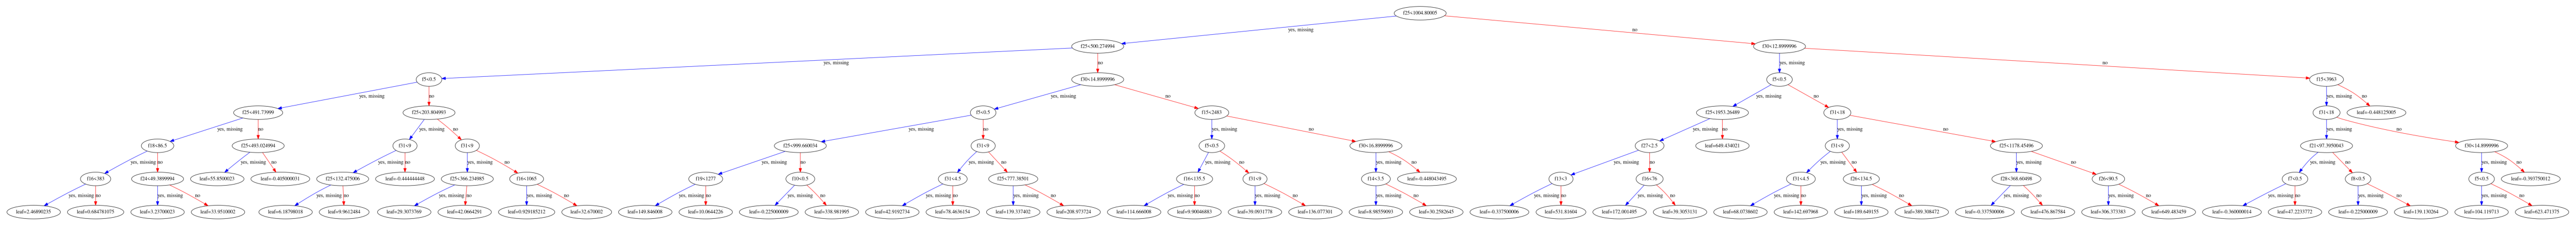

In [63]:
fig, ax = plt.subplots(figsize=(60, 100))
plot_tree(local_xgb_model, ax=ax)

In [65]:
print(loan_offers_hist.columns[25])
print(loan_offers_hist.columns[30])
print(loan_offers_hist.columns[5])

last_debit_value
loan_rate_offered
categorical__bad_debt_flag_N


#### XGBoost Performance Metrics

In [18]:
# preds = xgb_predictor.predict(loan_offers_hist_test.to_numpy())

preds_train = [float(s) for s in xgb_predictor.predict(loan_offers_hist_train.to_numpy()[0:20000]).decode('utf-8').split(',')]
print(len(preds_train))

preds_test = [float(s) for s in xgb_predictor.predict(loan_offers_hist_test.to_numpy()).decode('utf-8').split(',')]
print(len(preds_test))

8000
2000


In [22]:
loanval_sq_errs_test_train = []
for idx in range(0, loanval_y_train.shape[0]):
    loanval_sq_errs_test_train.append(pow(loanval_y_train.iloc[idx] - preds_train[idx], 2.0))

print("Performance on Training Set:")
print("RMSE", sqrt(mean_squared_error(loanval_y_train, preds_train)))
print("stdev RSE", sqrt(np.std(loanval_sq_errs_test_train)))
print("max RSE", sqrt(np.amax(loanval_sq_errs_test_train)))
print("min RSE", sqrt(np.amin(loanval_sq_errs_test_train)))
print("R2", r2_score(loanval_y_train, preds_train))

loanval_sq_errs_test_test = []
for idx in range(0,loanval_y_test.shape[0]):
    loanval_sq_errs_test_test.append(pow(loanval_y_test.iloc[idx] - preds_test[idx], 2.0))

print()
print("Performance on Test Set:")
print("RMSE", sqrt(mean_squared_error(loanval_y_test, preds_test)))
print("stdev RSE", sqrt(np.std(loanval_sq_errs_test_test)))
print("max RSE", sqrt(np.amax(loanval_sq_errs_test_test)))
print("min RSE", sqrt(np.amin(loanval_sq_errs_test_test)))
print("R2", r2_score(loanval_y_test, preds_test))

Performance on Training Set:
RMSE 35.72687407606726
stdev RSE 198.7902900614973
max RSE 1706.920654296875
min RSE 0.00015289306640653422
R2 0.9990318973331666

Performance on Test Set:
RMSE 29.592012344162086
stdev RSE 157.4798723438928
max RSE 1029.8453903198242
min RSE 0.00020324707031704747
R2 0.9993587529918797


<a id="keras"></a>
## 3. Predicting Optimal Loan Offer Parameters with TensorFlow/Keras

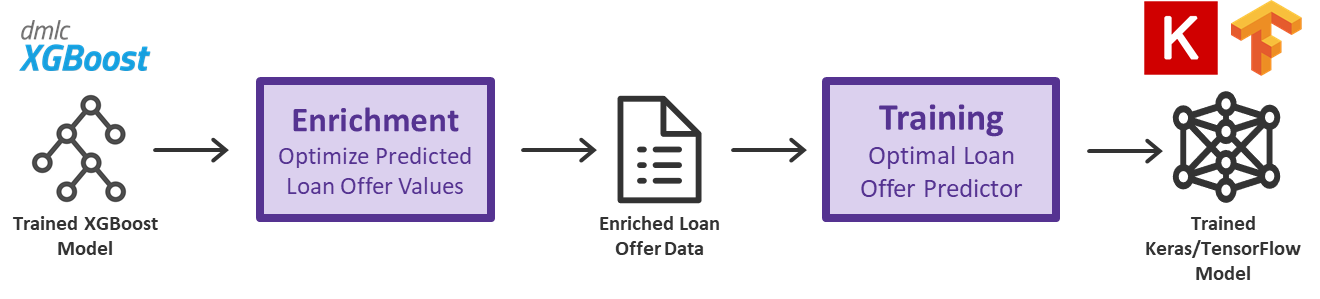

We train a three-headed dense neural network model implemented in Keras.
The three heads represent the loan interest rate, the loan period and the value of teh loan offer. 

<a id="optimisation"></a>
### 3A. Enriching the Data with Predicted Maximum Loan Value Parameters

To predict optimal loan offers, we change the original dataset dataset by replacing the 'loan rate offered' and 'loan term offered' (loan period) values, as well as the added 'loan value' feature, with an new rate/term/value value triplet.
The new triplet contains the rate and term values that produce the highest 'loan value'.

This maximum loan value triplet is found through a brute-force search of the rate/term space, where the XGBoost loan offer value model is called for all possible rate/term combinations to provide an estimated loan value.

The new dataset is used to train a model to predict the rate/term/loan value triplets directly.

In [23]:
print(loan_offers_hist.shape)

keep_cols = [col for col in loan_offers_hist if col not in ["loan_rate_offered", "loan_term_offered"]]
X_keep = loan_offers_hist[keep_cols]
# loan_rates_offered_train = X["loan_rate_offered"]
# loan_terms_offered_train = X["loan term offered"]

(10000, 32)


In [24]:
rate_options = [9.9, 11.9, 13.9, 15.9, 17.9, 19.9]
term_options = [3.0, 6.0, 12.0, 24.0]

In [25]:
def optimal_loan(rec):
    max_val = -99999.9
    max_rate = 0
    max_term = 0
    for term in term_options:
        for rate in rate_options:
            query_rec = np.append(np.append(rec, rate), term).reshape((1,32))
            val = float(xgb_predictor.predict(query_rec).decode('utf-8'))
            # print("rate", rate, "term", term, "val", val)
            if val > max_val:
                max_val = val
                max_rate = rate
                max_term = term
    return max_rate, max_term, max_val

In [26]:
test_opt_rec = X_keep.iloc[9961]

# test_opt_rec['categorical__bad_debt_flag_N'] = 0.0
# test_opt_rec['categorical__bad_debt_flag_Y'] = 1.0

# test_opt_rec['remainder__monthly_income'] = 2000

print(test_opt_rec)

to_rate, to_term, to_val = optimal_loan(test_opt_rec)
print()
print("optimal_rate", to_rate, "optimal_term", to_term, "optimal_value", to_val)

categorical__employment_status_Employed                            1.00
categorical__employment_status_Retired                             0.00
categorical__employment_status_Student                             0.00
categorical__homeowner_N                                           0.00
categorical__homeowner_Y                                           1.00
categorical__bad_debt_flag_N                                       0.00
categorical__bad_debt_flag_Y                                       1.00
categorical__last_debit_channel_App                                0.00
categorical__last_debit_channel_PoS                                1.00
categorical__last_debit_channel_Web                                0.00
categorical__last_debit_merchant_class_Fashion & Luxury            1.00
categorical__last_debit_merchant_class_Household & Consumer        0.00
categorical__last_debit_merchant_class_Travel & Leisure            0.00
pays_in_full_band                                               

In [32]:
start = time.time()
max_values = []
for idx in range(0, 100):  #X_keep.shape[0]):
    max_rate, max_term, max_val = optimal_loan(X_keep.iloc[idx])
    max_values.append([max_rate, max_term, max_val])
    
    # This is just to track progress across large datasets
    if idx % 1000 == 0:
        print(idx, end='')
    elif idx % 100 == 0:
        print(".", end='')
print()
    
max_values = np.array(max_values).reshape(100, 3)  # (X_keep.shape[0], 3))
end = time.time()
print("Time elapse:", end - start, "seconds")

max_values = pd.DataFrame(max_values, columns = ['loan_rate_offered', 'loan_term_offered', 'value'])
max_values.head()

0
Time elapse: 15.616284608840942 seconds


,loan_rate_offered,loan_term_offered,value
0,11.9,24.0,2573.831543
1,13.9,6.0,151.840347
2,13.9,12.0,739.290405
3,9.9,24.0,3491.660400
4,9.9,12.0,646.454163


In [33]:
for idx in range(0, 5): #max_values.shape[0):
    print(X_keep.iloc[idx]['categorical__bad_debt_flag_Y'], max_values.iloc[idx]['loan_rate_offered'], int(max_values.iloc[idx]['loan_term_offered']), max_values.iloc[idx]['value'])


0.0 11.9 24 2573.83154296875
0.0 13.9 6 151.84034729003906
0.0 13.9 12 739.2904052734375
0.0 9.9 24 3491.660400390625
0.0 9.9 12 646.4541625976562


In [34]:
# Save max values to local file and S3

# max_values.to_csv('loanval_max_values.csv')
# s3.Bucket(bucket).Object(os.path.join('loan-offer', 'loanval_max_values.csv')).upload_file('loanval_max_values.csv')

In [35]:
max_values = pd.read_csv("loanval_max_values.csv", index_col=0)
print(max_values.shape)

(10000, 3)


<a id="keras-data"></a>
### 3B. Data Preparation

#### Split Train and Test Sets

In [36]:
print(X_keep.iloc[0])
print(X_keep.shape)

categorical__employment_status_Employed                             1.00
categorical__employment_status_Retired                              0.00
categorical__employment_status_Student                              0.00
categorical__homeowner_N                                            0.00
categorical__homeowner_Y                                            1.00
categorical__bad_debt_flag_N                                        1.00
categorical__bad_debt_flag_Y                                        0.00
categorical__last_debit_channel_App                                 0.00
categorical__last_debit_channel_PoS                                 1.00
categorical__last_debit_channel_Web                                 0.00
categorical__last_debit_merchant_class_Fashion & Luxury             1.00
categorical__last_debit_merchant_class_Household & Consumer         0.00
categorical__last_debit_merchant_class_Travel & Leisure             0.00
pays_in_full_band                                  

In [37]:
# for col in X_keep.columns:
#     print(col)
maxval_X = X_keep.to_numpy()
maxval_Y = max_values.to_numpy()
maxval_X_train, maxval_X_test, maxval_Y_train, maxval_Y_test = train_test_split(maxval_X, maxval_Y, test_size=0.2)
print("maxval_X_train shape", maxval_X_train.shape)
print("maxval_X_test shape", maxval_X_test.shape)
print("maxval_Y_train shape", maxval_Y_train.shape)
print("maxval_Y_test shape", maxval_Y_test.shape)
print("maxval_Y_test", maxval_Y_test[0:4])

y_rates_train = maxval_Y_train[:,0]
y_terms_train = maxval_Y_train[:,1]
y_values_train = maxval_Y_train[:,2]
print("y_rates_train shape", y_rates_train.shape)
print("y_terms_train shape", y_terms_train.shape)
print("y_values_train shape", y_values_train.shape)

y_rates_test = maxval_Y_test[:,0]
y_terms_test = maxval_Y_test[:,1]
y_values_test = maxval_Y_test[:,2]
print("y_rates_test shape", y_rates_test.shape)
print("y_terms_test shape", y_terms_test.shape)
print("y_values_test shape", y_values_test.shape)

maxval_X_train shape (8000, 30)
maxval_X_test shape (2000, 30)
maxval_Y_train shape (8000, 3)
maxval_Y_test shape (2000, 3)
maxval_Y_test [[ 17.9          6.         167.20677185]
 [ 17.9          3.          20.61901665]
 [ 11.9         12.         696.26977539]
 [ 15.9          3.          63.54894638]]
y_rates_train shape (8000,)
y_terms_train shape (8000,)
y_values_train shape (8000,)
y_rates_test shape (2000,)
y_terms_test shape (2000,)
y_values_test shape (2000,)


#### Normalizing the Data

In [38]:
maxval_X_scaler = StandardScaler()
maxval_X_scaler.fit(maxval_X)
maxval_Y_scaler = StandardScaler()
maxval_Y_scaler.fit(maxval_Y)

maxval_X_train_scaled = maxval_X_scaler.transform(maxval_X_train)
maxval_X_test_scaled = maxval_X_scaler.transform(maxval_X_test)

maxval_Y_train_scaled = maxval_Y_scaler.transform(maxval_Y_train)
y_train_rates_scaled = np.array(maxval_Y_train_scaled[:,0]).reshape(maxval_Y_train_scaled.shape[0],1)
y_train_terms_scaled = np.array(maxval_Y_train_scaled[:,1]).reshape(maxval_Y_train_scaled.shape[0],1)
y_train_values_scaled = np.array(maxval_Y_train_scaled[:,2]).reshape(maxval_Y_train_scaled.shape[0],1)
  
maxval_Y_scaler.fit(maxval_Y_test)
print("maxval_Y_test shape", maxval_Y_test.shape)
maxval_Y_test_scaled = maxval_Y_scaler.transform(maxval_Y_test)
y_test_rates_scaled = np.array(maxval_Y_test_scaled[:,0]).reshape(maxval_Y_test_scaled.shape[0],1)
y_test_terms_scaled = np.array(maxval_Y_test_scaled[:,1]).reshape(maxval_Y_test_scaled.shape[0],1)
y_test_values_scaled = np.array(maxval_Y_test_scaled[:,2]).reshape(maxval_Y_test_scaled.shape[0],1)

maxval_Y_test shape (2000, 3)


#### Save Standardizing Object to S3 

In [423]:
# Save the columntransformer in S3 so it can be used by the lambda function
pickle.dump(maxval_X_scaler, open('maxval_x_scaler.pkl','wb'))
pickle.dump(maxval_Y_scaler, open('maxval_y_scaler.pkl','wb'))

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join('loan-offer', 'maxval_x_scaler.pkl')).upload_file('maxval_x_scaler.pkl')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join('loan-offer', 'maxval_y_scaler.pkl')).upload_file('maxval_y_scaler.pkl')

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


#### Save Data to S3

In [424]:
# maxval_train_scaled = pd.DataFrame(np.concatenate([y_train_rates_scaled, y_train_terms_scaled, y_train_values_scaled, maxval_X_train_scaled], axis=1))
# maxval_test_scaled = pd.DataFrame(np.concatenate([y_test_rates_scaled, y_test_terms_scaled, y_test_values_scaled, maxval_X_test_scaled], axis=1))

pd.DataFrame(maxval_X_train_scaled).to_csv('maxval_X_train_scaled.csv', header=False, index=False)
pd.DataFrame(maxval_X_test_scaled).to_csv('maxval_X_test_scaled.csv', header=False, index=False)
pd.DataFrame(maxval_Y_train_scaled).to_csv('maxval_Y_train_scaled.csv', header=False, index=False)
pd.DataFrame(maxval_Y_test_scaled).to_csv('maxval_Y_test_scaled.csv', header=False, index=False)

s3.Bucket(bucket).Object(os.path.join('loan-offer', 'maxval_X_train_scaled.csv')).upload_file('maxval_X_train_scaled.csv')
s3.Bucket(bucket).Object(os.path.join('loan-offer', 'maxval_X_test_scaled.csv')).upload_file('maxval_X_test_scaled.csv')
s3.Bucket(bucket).Object(os.path.join('loan-offer', 'maxval_Y_train_scaled.csv')).upload_file('maxval_Y_train_scaled.csv')
s3.Bucket(bucket).Object(os.path.join('loan-offer', 'maxval_Y_test_scaled.csv')).upload_file('maxval_Y_test_scaled.csv')

#### Read Data from File
This is only necessary if you haven't executed all the cells above.

In [46]:
maxval_X_train_scaled = pd.read_csv('maxval_X_train_scaled.csv', header=None)
maxval_X_test_scaled = pd.read_csv('maxval_X_test_scaled.csv', header=None)
maxval_Y_train_scaled = pd.read_csv('maxval_Y_train_scaled.csv', header=None)
maxval_Y_test_scaled = pd.read_csv('maxval_Y_test_scaled.csv', header=None)
print(maxval_X_train_scaled.shape, maxval_X_test_scaled.shape, maxval_Y_train_scaled.shape, maxval_Y_test_scaled.shape)


(8000, 30) (2000, 30) (8000, 3) (2000, 3)


<a id="keras-model"></a>
### 3C. The Three-Headed Keras Model

In [39]:
tensorflow_logs_path = "s3://{}/{}/logs".format(bucket, "loan-offer")

hyperparameters = {"epochs": 100, "batch-size": 32}

# tensorboard_output_config = TensorBoardOutputConfig(
#        s3_output_path = "s3://{}/xor/tensorboard_log_folder".format(bucket)
# )

maxval_estimator = TensorFlow(
  entry_point = "maxval_keras_train.py",    # Your entry script
  role = role,
  framework_version = "2.1.0", # TensorFlow's version
  py_version = "py3",
  hyperparameters = hyperparameters,
  output_path = "s3://{}/loan-offer/models".format(bucket),
  instance_count = 1, # "The number of GPUs instances to use"
  # metric_definitions=keras_metric_definition,
  instance_type = "ml.p3.2xlarge", # "ml.p2.xlarge",
  # tensorboard_output_config=tensorboard_output_config,
  tags = tags
)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


#### Replicate Model Locally for Visualisation

In [116]:
#  This cell generates a keras functional model identical to the real model
# This model is for display purposes only and is not trained or used.
inp = Input(shape = 32, name = 'inp')
hidden1 = Dense(128, activation ='relu', kernel_initializer = 'he_normal', name = 'hidden1')(inp)
hidden2 = Dense(64, activation ='relu', kernel_initializer = 'he_normal', name = 'hidden2')(hidden1)
hidden3 = Dense(32, activation ='relu', kernel_initializer = 'he_normal', name = 'hidden3')(hidden2)
out_rate = Dense(1, activation='linear', name = 'out_rate')(hidden3)
out_term = Dense(1, activation='linear', name = 'out_term')(hidden3)
out_value = Dense(1, activation='linear', name = 'out_value')(hidden3)

model_fn = Model(inputs = inp, outputs = [out_rate, out_term,  out_value])

# sgd = SGD(learning_rate=0.1)
model_fn.compile(loss = ['mse', 'mse', 'mse'], optimizer = 'adam', metrics = [['accuracy'], ['accuracy'], ['accuracy']])

2023-02-24 14:36:48.560733: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


#### Visualize TensorFlow/Keras Model

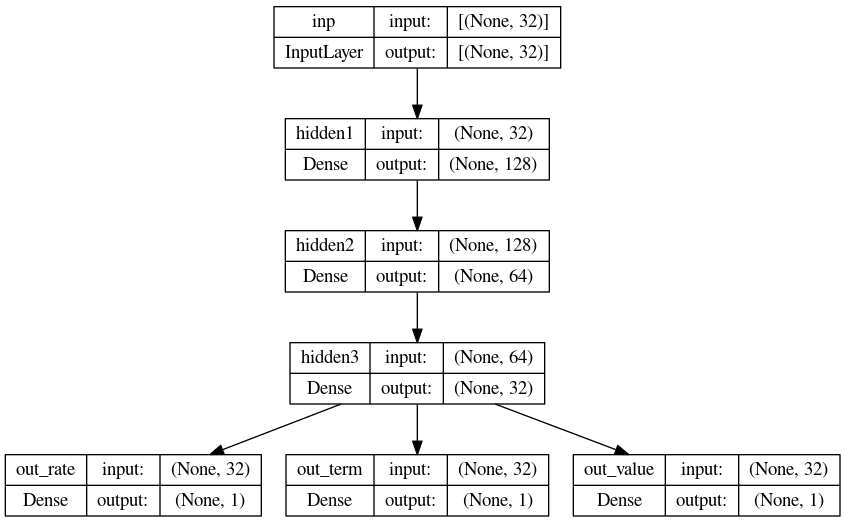

In [117]:
plot_model(model_fn, show_shapes=True)

<a id="keras-train"></a>
### 3D. Training the Keras Model

In [112]:
# Using a pre-deployed model
# A pre-deployed model does not need training or re-deploying, so you can skip those stages below
# Do this if you don't have time to re-train

# maxval_predictor = Predictor(endpoint_name="max-value-keras-202302231656", serializer=smk.serializers.CSVSerializer())

In [44]:
maxval_estimator.fit({"train": "s3://{}/{}/".format(bucket, "loan-offer")})

Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: tensorflow-training-2023-06-06-14-54-27-733


2023-06-06 14:54:28 Starting - Starting the training job...
2023-06-06 14:54:52 Starting - Preparing the instances for training.........
2023-06-06 14:56:07 Downloading - Downloading input data..................
2023-06-06 14:59:23 Training - Training image download completed. Training in progress..2023-06-06 14:59:27,772 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2023-06-06 14:59:28,104 sagemaker-containers INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "train": "/opt/ml/input/data/train"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "batch-size": 32,
        "epochs": 100,
        "model_dir": "s3://abinitio-active360-team/loan-offer/models/tensorflow-training-2023-06-06-14-40-40-317/model"
    },
    "input_config_dir": "/opt/ml

<a id="keras-deploy"></a>
### 3E. Deploying the Keras Model

In [428]:
maxval_datestamp = datetime.datetime.now().strftime("%Y%m%d%H%M")

maxval_predictor = maxval_estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    serializer=CSVSerializer(),
    endpoint_name="max-value-keras-" + maxval_datestamp
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.tensorflow.model:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating model with name: tensorflow-training-2023-05-04-17-52-45-207
INFO:sagemaker:Creating endpoint-config with name max-value-keras-202305041752
INFO:sagemaker:Creating endpoint with name max-value-keras-202305041752


------!

<a id="keras-eval"></a>
### 3F. Evaluating the Keras Model

#### TensorBoard

To get TensorBoard to work with p3.10, change line 3 in the file /home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/tensorboard/_vendor/html5lib/_trie/_base.py from 'from collections import Mapping' to 'from collections.abc import Mapping'.

To view the TensorBoard, point a browser to this URL (the final slash is critical)
https://instant-loan-mlp.notebook.us-east-1.sagemaker.aws/proxy/6006/

In [95]:
!ps -ax | grep tensorboard

 3741 ?        Z      0:03 [tensorboard] <defunct>
 4690 pts/1    Ss+    0:00 /bin/sh -c ps -ax | grep tensorboard
 4692 pts/1    S+     0:00 grep tensorboard
 9291 ?        Z      0:07 [tensorboard] <defunct>


In [94]:
!kill 30768

In [96]:
# %reload_ext tensorboard
%tensorboard --logdir=s3://abinitio-active360-team/loan-offer/tf_logs --host 0.0.0.0

#### Performace Metrics

In [429]:
# Get predictions for test dataset

# For a loaded model
# preds_json = maxval_predictor.predict(maxval_X_test_scaled) #.to_numpy()) #.decode("utf-8")
# preds_dict = json.loads(preds_json)

# For a newly trained model
preds_dict = maxval_predictor.predict(maxval_X_test_scaled.to_numpy()) #.decode("utf-8")
maxval_predictions = preds_dict["predictions"]
# maxval_predictions = json.loads(predictions_json)["predictions"]

print(maxval_predictions[0])
Y_scaled_pred = []
for pred in maxval_predictions:
    Y_scaled_pred.append([pred["out_rate"][0], pred["out_term"][0], pred["out_value"][0]])

# De-normalize predictions 
maxval_Y_test_rescaled_pred = maxval_Y_scaler.inverse_transform(Y_scaled_pred)
y_test_rates_rescaled_pred = maxval_Y_test_rescaled_pred[:,0]
y_test_terms_rescaled_pred = maxval_Y_test_rescaled_pred[:,1]
y_test_values_rescaled_pred = maxval_Y_test_rescaled_pred[:,2]

{'out_value': [-1.27613282], 'out_rate': [0.47107619], 'out_term': [-0.40642]}


In [430]:
# Calculate head-specific performance metrics
rate_ses = []
term_ses = []
value_ses = []
for idx in range(0,maxval_X_test.shape[0]):
    se_rate_rescaled = pow(y_rates_test[idx] - y_test_rates_rescaled_pred[idx], 2.0)
    se_term_rescaled = pow(y_terms_test[idx] - y_test_terms_rescaled_pred[idx], 2.0)
    se_value_rescaled = pow(y_values_test[idx] - y_test_values_rescaled_pred[idx], 2.0)
    rate_ses.append(se_rate_rescaled)
    term_ses.append(se_term_rescaled)
    value_ses.append(se_value_rescaled)
    # if idx >= 0 and idx < 2: # Indices to be printed out for reality checks
    #     print("y_rates[%d]: %f, y_rates_rescaled_pred[%d]: %f, rse: %f" % (idx, y_rates_test[idx], idx, y_test_rates_rescaled_pred[idx], sqrt(se_rate_rescaled)))
    #     print("y_terms[%d]: %f, y_terms_rescaled_pred[%d]: %f, rse: %f" % (idx, y_terms_test[idx], idx, y_test_terms_rescaled_pred[idx], sqrt(se_term_rescaled)))
    #     print("y_values[%d]: %f, y_values_rescaled_pred[%d]: %f, rse: %f" % (idx, y_values_test[idx], idx, y_test_values_rescaled_pred[idx], sqrt(se_value_rescaled)))
    #     print()
             
print("rates: RMSE %f, max RSE %f, min RSE %f, R2 %f" % \
      (sqrt(mean_squared_error(y_rates_test,y_test_rates_rescaled_pred)),
       sqrt(np.amax(rate_ses)),
       sqrt(np.amin(rate_ses)),
       r2_score(y_rates_test, y_test_rates_rescaled_pred))
     )
print("terms: RMSE %f, max RSE %f, min RSE %f, R2 %f" % \
      (sqrt(mean_squared_error(y_terms_test, y_test_terms_rescaled_pred)),
       sqrt(np.amax(term_ses)),
       sqrt(np.amin(term_ses)),
       r2_score(y_terms_test, y_test_terms_rescaled_pred))
     )
print("values: RMSE %f, max RSE %f, min RSE %f, R2 %f" % \
      (sqrt(mean_squared_error(y_values_test, y_test_values_rescaled_pred)),
       sqrt(np.amax(value_ses)),
       sqrt(np.amin(value_ses)),
       r2_score(y_values_test, y_test_values_rescaled_pred))
    )

rates: RMSE 2.080622, max RSE 7.521929, min RSE 0.000098, R2 0.564327
terms: RMSE 3.222996, max RSE 17.792814, min RSE 0.000755, R2 0.782512
values: RMSE 144.399850, max RSE 865.145363, min RSE 0.045126, R2 0.984417


#### Result Analysis

In [434]:
# Analyse single record

record_idx = 1

rec = features.iloc[record_idx].copy()
rec['monthly_income'] = 2050
rec['homeowner'] = "N"
rec['bad_debt_flag'] = "N"
print(rec)


employment_status                                  Employed
monthly_income                                         2050
months_in_employment                                    710
homeowner                                                 N
assets_under_management                                   0
age                                                      63
bad_debt_flag                                             N
pays_in_full_band                                         D
pays_on_time_band                                         E
total_credit_granted                                   2110
current_balance                                      2088.0
total_credit_used                                     98.86
max_daily_closing_balance_last_90d                   2088.0
avg_daily_closing_balance_last_90d                164993.77
avg_daily_closing_balance_vs_limit_perc                78.2
last_debit_value                                     458.36
last_debit_channel                      

In [435]:
rec_enc_list = ct.transform([rec])[0]

rec_enc = pd.DataFrame(data=np.array(rec_enc_list).reshape(1,32), columns=features_encoded_cols)
in_cols = [col for col in features_encoded_cols if col not in ["loan_rate_offered", "loan_term_offered"]]
print("Encoded:")
print(rec_enc[in_cols].iloc[0])

rec_scaled = maxval_X_scaler.transform(rec_enc[in_cols])
print()
print("Scaled:")
print(rec_scaled)


Encoded:
categorical__employment_status_Employed                              1.0
categorical__employment_status_Retired                               0.0
categorical__employment_status_Student                               0.0
categorical__homeowner_N                                             1.0
categorical__homeowner_Y                                             0.0
categorical__bad_debt_flag_N                                         1.0
categorical__bad_debt_flag_Y                                         0.0
categorical__last_debit_channel_App                                  0.0
categorical__last_debit_channel_PoS                                  1.0
categorical__last_debit_channel_Web                                  0.0
categorical__last_debit_merchant_class_Fashion & Luxury              0.0
categorical__last_debit_merchant_class_Household & Consumer          0.0
categorical__last_debit_merchant_class_Travel & Leisure              1.0
pays_in_full_band                         

In [436]:
# For loaded model
# rec_preds_json = maxval_predictor.predict(rec_scaled)
# rec_preds_dict = json.loads(rec_preds_json)['predictions'][0]

# For newly trained model
rec_preds_dict = maxval_predictor.predict(rec_scaled)['predictions'][0]

print(rec_preds_dict)

preds_list = maxval_Y_scaler.inverse_transform(np.array([rec_preds_dict['out_rate'], rec_preds_dict['out_term'], rec_preds_dict['out_value']]).reshape(1, 3))[0]
pd.DataFrame(preds_list.reshape(1, 3), columns=['out_rate', 'out_term', 'out_value'])

{'out_term': [-0.470063686], 'out_value': [-0.129154041], 'out_rate': [0.619524598]}


,out_rate,out_term,out_value
0,15.530861,7.059383,307.635634
